# Applied ML - Car Insurance Claim Prediction


In [13]:
import pickle
import numpy as np
import pandas as pd

In [29]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt

## Model Retreival

In [14]:
# File path to your .pkl file to retrieve previously run model
file_path = './pkl_store/partsOS_models.pkl'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the object from the file
    parts_processor = pickle.load(file)

## Find Best Model for each Car Segment (Model)

In [15]:
results = {}
for car_model, models in parts_processor.model_results_by_stratify.items():
    results[car_model] = {}
    for model,model_metrics in models.items():
        results[car_model][model] = model_metrics["results"]['f1-score']
results_df = pd.DataFrame(results)
results_df

,M1,M4,M6,M8,M7,M3,M9,M5,Other
Logistic Regression,0.132530,0.145803,0.149492,0.154341,0.148936,0.105263,0.105263,0.176991,0.151261
Decision Tree,0.157068,0.127045,0.153749,0.193798,0.150376,0.106509,0.099448,0.105263,0.187234
Random Forest,0.166227,0.153404,0.146514,0.132159,0.155172,0.088235,0.089552,0.125000,0.203704
KNN,0.107798,0.115976,0.141696,0.146789,0.107784,0.086957,0.153846,0.146341,0.136752
SVM,0.138496,0.152950,0.167539,0.118467,0.131455,0.131148,0.131387,0.161616,0.156250


In [16]:
best_models_by_segment = results_df.idxmax()
best_models_by_segment

M1             Random Forest
M4             Random Forest
M6                       SVM
M8             Decision Tree
M7             Random Forest
M3                       SVM
M9                       KNN
M5       Logistic Regression
Other          Random Forest
dtype: object

## Computing the Performance of Best ML Model for each Car Segment

In [21]:
# Create storage to store predictions from each car model
y_pred_global = pd.Series(np.zeros(parts_processor.y_test.shape), index=parts_processor.y_test.index)
# Loop through the saved results to find the best model: 
for car_model, models in parts_processor.model_results_by_stratify.items():
    if car_model == "Other":
        # Find the subsegement of the data for X_train, y_train, and X_test
        X_train_temp = parts_processor.X_train[parts_processor.unenc_X_train["model"].isin(["M10","M11","M2"])]
        y_train_temp = parts_processor.y_train[parts_processor.unenc_X_train["model"].isin(["M10","M11","M2"])]
        X_test_temp = parts_processor.X_test[parts_processor.unenc_X_test["model"].isin(["M10","M11","M2"])]
        test_indices = parts_processor.X_test[parts_processor.unenc_X_test["model"].isin(["M10","M11","M2"])].index
    else:
        X_train_temp = parts_processor.X_train[parts_processor.unenc_X_train["model"] == car_model]
        y_train_temp = parts_processor.y_train[parts_processor.unenc_X_train["model"] == car_model]
        X_test_temp = parts_processor.X_test[parts_processor.unenc_X_test["model"] == car_model]
        test_indices = parts_processor.X_test[parts_processor.unenc_X_test["model"] == car_model].index

    # Find the location where the best model is stored
    mod_model_obj = parts_processor.model_results_by_stratify[car_model][best_models_by_segment[car_model]]['model']
    # Create predictions on just the X_test observations that match the current car model
    y_pred_temp = mod_model_obj.predict(X_test_temp)
    # store the results in a global variable
    y_pred_global[test_indices] = y_pred_temp

# compute classification parameters
mixed_model_results = parts_processor.compute_results(parts_processor.y_test, y_pred_global)

### View Results

In [22]:
# Extracting confusion matrix separately for better display
confusion_matrix = mixed_model_results.pop("confusion matrix")

# Convert the remaining dictionary into a pandas DataFrame
results_df = pd.DataFrame(mixed_model_results, index=["Value"]).T

# Print the main results
print("Model Metrics:")
print(results_df)

Model Metrics:
               Value
accuracy    0.705180
precision   0.100709
recall      0.454061
f1-score    0.164854
auc         0.588218
log loss   10.626403


In [23]:
# Display the confusion matrix as a separate DataFrame
confusion_matrix_df = pd.DataFrame(confusion_matrix, 
                                   columns=["Predicted Negative", "Predicted Positive"], 
                                   index=["Actual Negative", "Actual Positive"]
                                  )

print("\nConfusion Matrix:")
print(confusion_matrix_df)


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                7923                3045
Actual Positive                 410                 341


### Visualize Results

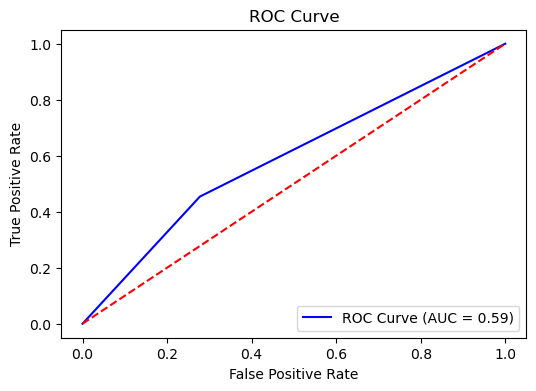

In [27]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(parts_processor.y_test, y_pred_global)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

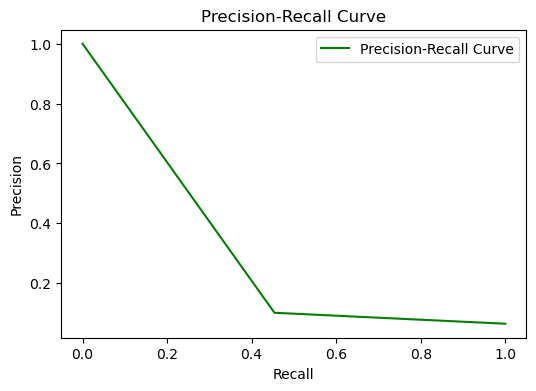

In [31]:
# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(parts_processor.y_test, y_pred_global)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green', label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()